## Libraries and Settings

In [1]:
# data manipulation
import numpy as np
import pandas as pd
import datetime
from scipy import stats
import PyPDF2
import os
import re

# data viz
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import ticker
import seaborn as sns
import matplotlib.dates as mdates


#warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Viz Styling
plt.style.use('default')
rcParams['figure.figsize'] = (12,  6)
pd.set_option('display.max_columns',50)


## Import Data

In [2]:
trips = pd.read_excel('data/RAW-2019-Chevy-Bolt-Trip-Data.xlsx')

trips.head()

,Vehicle Model,Start Date,End Date,Duration,Distance (mi),Gasoline Consumed (gal),Electricity Consumed (kWh),Fuel Efficiency Equivalent (MPGeq),mi/kWh,Starting SOC (%),Ending SOC (%),Ambient Temperature (F),Smooth Acceleration (%),Smooth Braking (%)
0,2019 Chevrolet Bolt EV,2022-06-25 20:18:33,2022-06-25 20:25:43,00:07:10,1.59,NaN,0.01,5374.05,159.000000,76.08,76.08,NaN,NaN,NaN
1,2019 Chevrolet Bolt EV,2022-07-16 20:43:47,2022-07-16 20:48:01,00:04:14,0.79,NaN,0.02,1327.81,39.500000,83.92,83.92,78.80,NaN,NaN
2,2019 Chevrolet Bolt EV,2022-07-26 16:16:48,2022-07-26 16:23:35,00:06:47,1.91,NaN,0.06,1072.65,31.833333,70.98,70.58,80.60,NaN,NaN
3,2019 Chevrolet Bolt EV,2022-05-18 20:33:28,2022-05-18 20:39:32,00:06:04,1.81,NaN,0.06,1016.80,30.166667,38.04,37.64,NaN,NaN,NaN
4,2019 Chevrolet Bolt EV,2022-11-03 16:38:58,2022-11-03 16:43:54,00:04:56,1.60,NaN,0.06,900.91,26.666667,68.24,67.84,65.73,NaN,NaN


In [3]:
# Finding null columns
np.sum(~trips.isnull())

Vehicle Model                         1201
Start Date                            1201
End Date                              1201
Duration                              1201
Distance (mi)                         1201
Gasoline Consumed (gal)                  0
Electricity Consumed (kWh)            1199
Fuel Efficiency Equivalent (MPGeq)    1110
mi/kWh                                1201
Starting SOC (%)                      1201
Ending SOC (%)                        1201
Ambient Temperature (F)               1011
Smooth Acceleration (%)                  0
Smooth Braking (%)                       0
dtype: int64

## Cleaning

In [4]:
# Removing Null Columns and irrelivant columns
trips.drop(labels = ['Vehicle Model', r'Gasoline Consumed (gal)'\
                     , r'Smooth Acceleration (%)', r'Smooth Braking (%)'], axis = 1, inplace = True)

In [5]:
# Removing 0.00 mile trips (i.e. I turned on the car for a minute, but didn't go anywhere)
trips = trips.loc[trips[r'Distance (mi)'] != 0 ,:]

# Removing negative electricity_consumed outliers.
trips = trips.loc[trips[r'Electricity Consumed (kWh)'] >= 0,:]


In [6]:
# converting SOC columns to decimal values (/100)
trips[r'Starting SOC (%)'] = trips[r'Starting SOC (%)']/100
trips[r'Ending SOC (%)'] = trips[r'Ending SOC (%)']/100

In [7]:
# Appending Columns to provide additional Analysis
# Projected Mile Range at Star and end of trip
# Using the formula (mi/kWh)*(SOC*battery size)
# battery size is 66kWh
battery_size = 66

trips['start_range'] = trips['mi/kWh']*(trips[r'Starting SOC (%)']*battery_size)
trips['end_range'] = trips['mi/kWh']*(trips[r'Ending SOC (%)']*battery_size)

In [8]:
trips.columns

Index(['Start Date', 'End Date', 'Duration', 'Distance (mi)',
       'Electricity Consumed (kWh)', 'Fuel Efficiency Equivalent (MPGeq)',
       'mi/kWh', 'Starting SOC (%)', 'Ending SOC (%)',
       'Ambient Temperature (F)', 'start_range', 'end_range'],
      dtype='object')

In [9]:
# Rename column names
trips = trips.rename(columns = {r'Start Date' : 'start_date',
           r'End Date' : 'end_date',
           r'Duration' : 'duration',
           r'Distance (mi)' : 'distance',
           r'Electricity Consumed (kWh)' : 'electricity_used',
           r'mi/kWh' : 'mikWh',
           r'Fuel Efficiency Equivalent (MPGeq)' : 'MPGe',
           r'Starting SOC (%)' : 'start_soc',
           r'Ending SOC (%)' : 'end_soc',
           r'Ambient Temperature (F)' : 'temp',
          }
         )

In [10]:
# trips['start_date'] = pd.to_datetime(trips['start_date']).dt.date
# trips['start_time'] = pd.to_datetime(trips['start_date']).dt.time
# trips['end_date'] = pd.to_datetime(trips['end_date']).dt.date
# trips['end_time'] = pd.to_datetime(trips['end_date']).dt.time

# trips

## Handling Missing Data

In [11]:
# Finding missing data
np.sum(~trips.isnull())

start_date          1092
end_date            1092
duration            1092
distance            1092
electricity_used    1092
MPGe                1092
mikWh               1092
start_soc           1092
end_soc             1092
temp                 924
start_range         1092
end_range           1092
dtype: int64

## Temperature NaN Values

There does not seem to be a pattern regarding the missing temperature data. 

There are 168 temperature data points missing, out of a total of 1092 data points. 

***13%*** of the temperature data points are missing. I have chosen to interpolate the missing data with a linear model. 

In [12]:
trips[trips.temp.isnull()].sort_values('start_date')#.describe()

,start_date,end_date,duration,distance,electricity_used,MPGe,mikWh,start_soc,end_soc,temp,start_range,end_range
961,2022-03-05 15:51:54,2022-03-05 15:59:33,00:07:39,1.62,0.69,79.34,2.347826,0.7647,0.7568,NaN,118.495252,117.271096
527,2022-03-09 17:18:45,2022-03-09 17:20:06,00:01:21,0.12,0.03,136.13,4.000000,0.7058,0.7098,NaN,186.331200,187.387200
528,2022-03-11 00:54:56,2022-03-11 00:55:33,00:00:37,0.04,0.01,148.70,4.000000,0.3020,0.3020,NaN,79.728000,79.728000
1047,2022-03-12 07:59:54,2022-03-12 08:01:07,00:01:13,0.01,0.01,20.94,1.000000,0.4824,0.5333,NaN,31.838400,35.197800
367,2022-03-19 16:05:20,2022-03-19 16:09:49,00:04:29,0.72,0.16,150.92,4.500000,0.5804,0.6000,NaN,172.378800,178.200000
...,...,...,...,...,...,...,...,...,...,...,...,...
673,2022-11-19 15:25:29,2022-11-19 16:10:34,00:45:05,23.87,6.63,121.36,3.600302,0.8118,0.6941,NaN,192.899843,164.931979
5,2022-11-22 12:44:33,2022-11-22 12:49:55,00:05:22,1.60,0.06,899.52,26.666667,0.9137,0.9137,NaN,1608.112000,1608.112000
772,2022-11-25 08:21:56,2022-11-25 09:07:08,00:45:12,35.56,10.62,112.87,3.348399,0.5098,0.3255,NaN,112.662920,71.933661
740,2022-11-27 13:47:42,2022-11-27 13:49:15,00:01:33,0.24,0.07,115.19,3.428571,0.9882,0.9882,NaN,223.615543,223.615543


In [13]:
# SORT by date then Interpolate Missing data points based on recent days
trips['temp'] = trips.sort_values('start_date').temp.interpolate(method = 'linear')

# new 'temp' column missing data points
np.sum(trips['temp'].isnull()) # 0

0

## Write clean data to .csv

In [14]:
trips.to_csv('data/CLEAN-2019-Chevy-Bolt-Trip-Data.csv', sep=',', encoding='utf-8')

## Data Summary

In [94]:
trips.describe()

,distance,electricity_used,MPGe,mikWh,start_soc,end_soc,temp,start_range,end_range,gas_price,gas_used_eq,trip_cost_gas_car_eq
count,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000
mean,15.934625,3.893306,152.240824,4.515056,0.726474,0.663368,65.677898,216.435830,199.327548,4.185158,0.497957,2.073868
std,23.537214,5.667625,184.777458,5.470657,0.161817,0.184336,15.691951,275.939166,277.616239,0.433274,0.735538,3.127339
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,23.420000,0.000000,0.000000,3.483000,0.000313,0.001088
25%,1.707500,0.390000,107.897500,3.201098,0.653925,0.567625,53.570000,139.373270,117.428309,3.750000,0.053359,0.219539
50%,5.290000,1.215000,132.995000,3.946428,0.749000,0.690200,67.725000,189.269131,168.324154,4.173000,0.165313,0.665157
75%,18.500000,5.230000,165.630000,4.913897,0.815600,0.764700,78.800000,250.614535,231.463846,4.463000,0.578125,2.549204
max,177.480000,42.320000,5374.050000,159.000000,1.000000,1.000000,99.540000,7983.835200,7983.835200,4.938000,5.546250,25.913114


In [147]:
trips[trips.distance>18].corr().temp.mikWh

0.5628122399055947

## Does Distance have an Effect on Effeciency?

In [17]:
# Quick Look at counts at different distances
short_trips = trips.loc[trips.distance<3.3]
med_trips = trips.loc[(trips.distance>=3.3) & (trips.distance<18)]
long_trips = trips.loc[trips.distance>=18]
print(short_trips.distance.count())
print(med_trips.distance.count())
print(long_trips.distance.count())

419
394
279


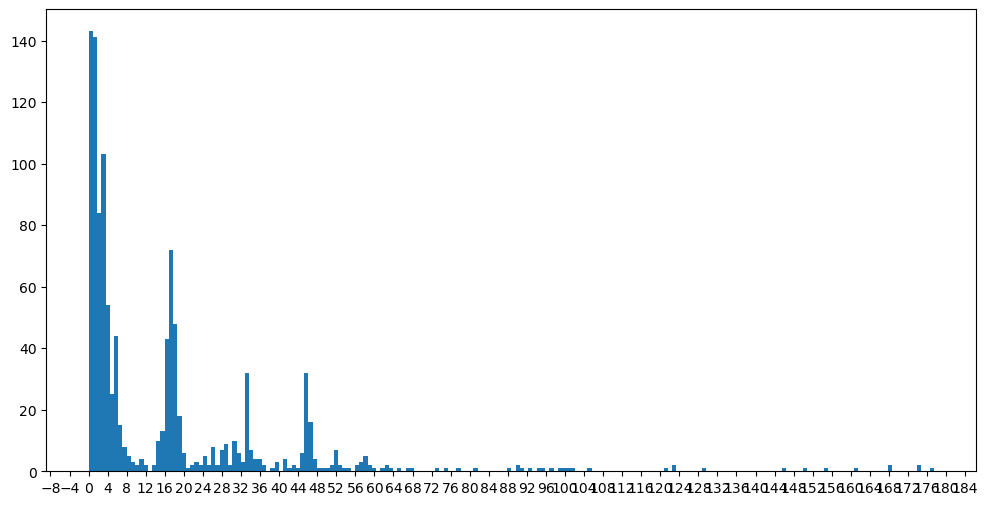

In [18]:
fig, ax = plt.subplots()
ax.hist(trips.distance, bins = 200)
ax.xaxis.set_major_locator(ticker.MultipleLocator(4));

In [19]:
# creating quick function to append column with a category for how long the trip was
def distance_describer(x):
    if x['distance'] < 3.3:
        return 'Short Trip'
    if (x['distance'] >= 3.3) & (x['distance'] <18):
        return 'Medium Trip'
    if x['distance'] >= 18:
        return 'Long Trip'

In [20]:
#appending Column to Dataframe describing if the trip was short, medium, or long
trips['distance_desc'] = trips.apply(lambda x: distance_describer(x), axis = 1)
trips

,start_date,end_date,duration,distance,electricity_used,MPGe,mikWh,start_soc,end_soc,temp,start_range,end_range,distance_desc
0,2022-06-25 20:18:33,2022-06-25 20:25:43,00:07:10,1.59,0.01,5374.05,159.000000,0.7608,0.7608,82.120000,7983.8352,7983.8352,Short Trip
1,2022-07-16 20:43:47,2022-07-16 20:48:01,00:04:14,0.79,0.02,1327.81,39.500000,0.8392,0.8392,78.800000,2187.7944,2187.7944,Short Trip
2,2022-07-26 16:16:48,2022-07-26 16:23:35,00:06:47,1.91,0.06,1072.65,31.833333,0.7098,0.7058,80.600000,1491.2898,1482.8858,Short Trip
3,2022-05-18 20:33:28,2022-05-18 20:39:32,00:06:04,1.81,0.06,1016.80,30.166667,0.3804,0.3764,61.855000,757.3764,749.4124,Short Trip
4,2022-11-03 16:38:58,2022-11-03 16:43:54,00:04:56,1.60,0.06,900.91,26.666667,0.6824,0.6784,65.730000,1201.0240,1193.9840,Short Trip
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,2022-06-30 14:31:39,2022-06-30 14:32:00,00:00:21,0.01,0.00,0.00,0.000000,0.5882,0.5804,82.400000,0.0000,0.0000,Short Trip
1162,2022-07-03 08:20:48,2022-07-03 08:21:02,00:00:14,0.01,0.00,0.00,0.000000,0.6470,0.6470,66.200000,0.0000,0.0000,Short Trip
1168,2022-07-29 13:43:33,2022-07-29 13:43:53,00:00:20,0.01,0.00,0.00,0.000000,0.7568,0.7568,81.456667,0.0000,0.0000,Short Trip
1171,2022-08-15 12:30:25,2022-08-15 12:30:40,00:00:15,0.01,0.00,0.00,0.000000,0.6196,0.6196,83.545000,0.0000,0.0000,Short Trip


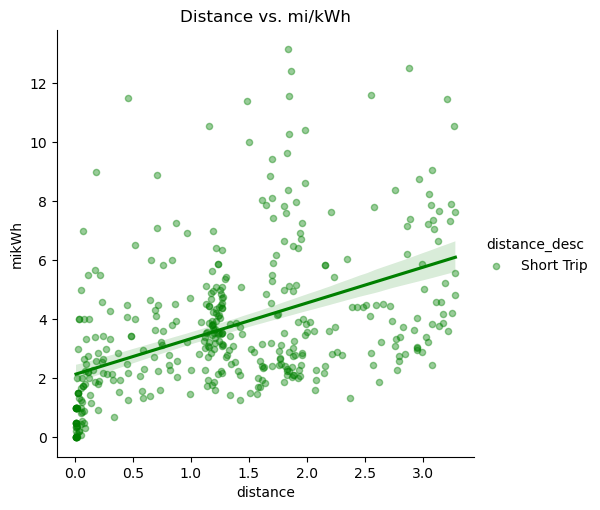

In [105]:
sns.lmplot(x='distance', y='mikWh', data=trips[(trips.mikWh<15)&(trips.distance_desc == 'Short Trip')], hue='distance_desc',\
           palette = ['green','blue', 'red'], scatter_kws={"s": 20, "alpha":.4})
plt.title('Distance vs. mi/kWh');

In [ ]:
sns.lmplot(x='distance', y='mikWh', data=trips[(trips.mikWh<15)&(trips.distance_desc == 'Medium Trip')], hue='distance_desc',\
           palette = ['green','blue', 'red'], scatter_kws={"s": 20, "alpha":.4})
plt.title('Trips < 3.3mi Effeciency');

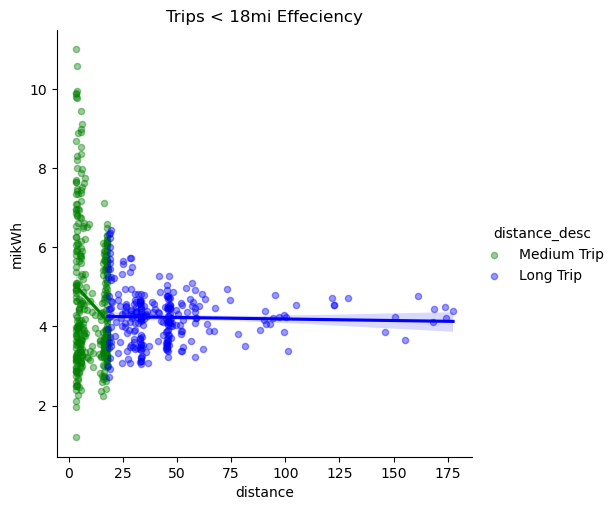

In [107]:
sns.lmplot(x='distance', y='mikWh',\
           data=trips[(trips.mikWh<15)&((trips.distance_desc == 'Long Trip')|(trips.distance_desc == 'Medium Trip'))], hue='distance_desc',\
           palette = ['green','blue', 'red'], scatter_kws={"s": 20, "alpha":.4})
plt.title('Trips < 18mi Effeciency');

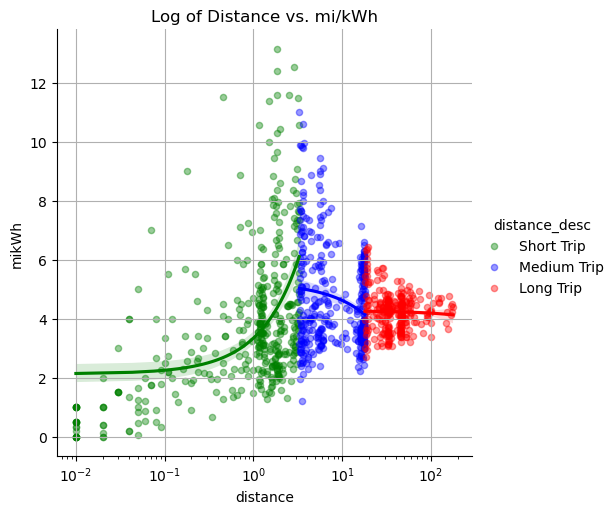

In [22]:
g = sns.lmplot(x='distance', y='mikWh', data=trips[trips.mikWh<15],\
               hue='distance_desc', palette = ['green','blue', 'red'], scatter_kws={"s": 20, "alpha":.4})
g.set(xscale="log") 
plt.title('Log of Distance vs. mi/kWh')
plt.grid(which='major');

## Does time of day have an Effect on Effeciency?

In [23]:
def time_describe(x):
    if (x >= 0) and (x < 6):
        return 'Wee Hours'
    elif (x >= 6) and (x < 12):
        return 'Morning'
    elif (x >= 12) and (x <= 18):
        return'Afternoon'
    elif (x >= 16) and (x < 24) :
        return 'Night'

In [24]:
trips['time_desc'] = trips.start_date.dt.hour.apply(time_describe)
trips

,start_date,end_date,duration,distance,electricity_used,MPGe,mikWh,start_soc,end_soc,temp,start_range,end_range,distance_desc,time_desc
0,2022-06-25 20:18:33,2022-06-25 20:25:43,00:07:10,1.59,0.01,5374.05,159.000000,0.7608,0.7608,82.120000,7983.8352,7983.8352,Short Trip,Night
1,2022-07-16 20:43:47,2022-07-16 20:48:01,00:04:14,0.79,0.02,1327.81,39.500000,0.8392,0.8392,78.800000,2187.7944,2187.7944,Short Trip,Night
2,2022-07-26 16:16:48,2022-07-26 16:23:35,00:06:47,1.91,0.06,1072.65,31.833333,0.7098,0.7058,80.600000,1491.2898,1482.8858,Short Trip,Afternoon
3,2022-05-18 20:33:28,2022-05-18 20:39:32,00:06:04,1.81,0.06,1016.80,30.166667,0.3804,0.3764,61.855000,757.3764,749.4124,Short Trip,Night
4,2022-11-03 16:38:58,2022-11-03 16:43:54,00:04:56,1.60,0.06,900.91,26.666667,0.6824,0.6784,65.730000,1201.0240,1193.9840,Short Trip,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,2022-06-30 14:31:39,2022-06-30 14:32:00,00:00:21,0.01,0.00,0.00,0.000000,0.5882,0.5804,82.400000,0.0000,0.0000,Short Trip,Afternoon
1162,2022-07-03 08:20:48,2022-07-03 08:21:02,00:00:14,0.01,0.00,0.00,0.000000,0.6470,0.6470,66.200000,0.0000,0.0000,Short Trip,Morning
1168,2022-07-29 13:43:33,2022-07-29 13:43:53,00:00:20,0.01,0.00,0.00,0.000000,0.7568,0.7568,81.456667,0.0000,0.0000,Short Trip,Afternoon
1171,2022-08-15 12:30:25,2022-08-15 12:30:40,00:00:15,0.01,0.00,0.00,0.000000,0.6196,0.6196,83.545000,0.0000,0.0000,Short Trip,Afternoon


In [25]:
# Average efficiency by time of day
time_group = trips.groupby('time_desc')
time_group.mikWh.mean()

time_desc
Afternoon    4.558081
Morning      4.031660
Night        5.319164
Wee Hours    3.465224
Name: mikWh, dtype: float64

In [26]:
# Count of trips by time of day

time_group.start_date.count()

time_desc
Afternoon    572
Morning      341
Night        177
Wee Hours      2
Name: start_date, dtype: int64

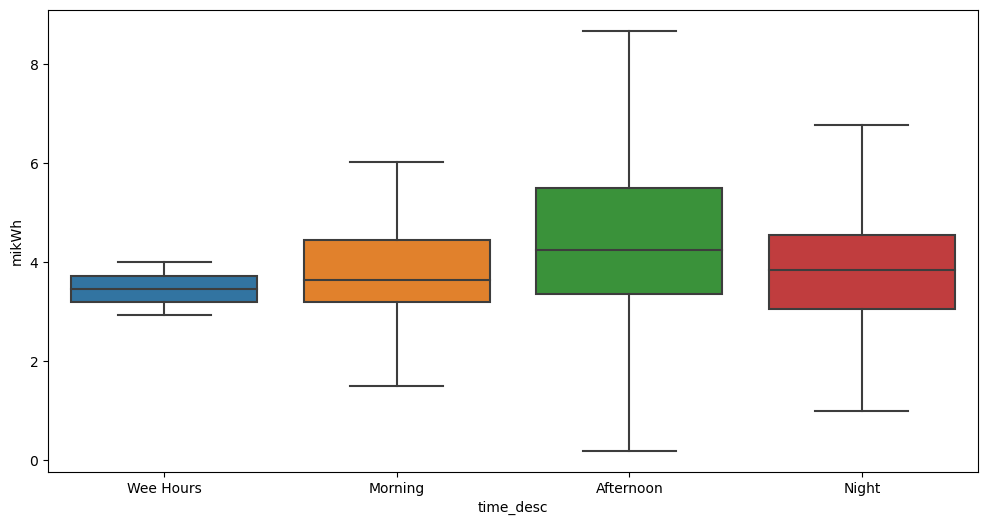

In [27]:
# fig, ax = plt.subplots()

y = trips.mikWh
x = trips.time_desc


sns.boxplot(x=x, y=y, data=trips, showfliers = False, order = ['Wee Hours','Morning','Afternoon','Night']);

# The shape exapands as the traffic conditions worsen.

# Column Analysis

## Skewness and Kurtosis

<img src="images/skewness.png" width="500" align = "left"/>

<img src="images/kurtosis.jpg" width="400" align = "left"/>

In [28]:
# Skewness: asymmetry from the norm
print(f"Skewness: {trips[r'temp'].skew()}")
print(f"Kurtosis: {trips[r'temp'].kurt()}")

Skewness: -0.3164235937086513
Kurtosis: -0.7083586398754513


In [29]:
trips

,start_date,end_date,duration,distance,electricity_used,MPGe,mikWh,start_soc,end_soc,temp,start_range,end_range,distance_desc,time_desc
0,2022-06-25 20:18:33,2022-06-25 20:25:43,00:07:10,1.59,0.01,5374.05,159.000000,0.7608,0.7608,82.120000,7983.8352,7983.8352,Short Trip,Night
1,2022-07-16 20:43:47,2022-07-16 20:48:01,00:04:14,0.79,0.02,1327.81,39.500000,0.8392,0.8392,78.800000,2187.7944,2187.7944,Short Trip,Night
2,2022-07-26 16:16:48,2022-07-26 16:23:35,00:06:47,1.91,0.06,1072.65,31.833333,0.7098,0.7058,80.600000,1491.2898,1482.8858,Short Trip,Afternoon
3,2022-05-18 20:33:28,2022-05-18 20:39:32,00:06:04,1.81,0.06,1016.80,30.166667,0.3804,0.3764,61.855000,757.3764,749.4124,Short Trip,Night
4,2022-11-03 16:38:58,2022-11-03 16:43:54,00:04:56,1.60,0.06,900.91,26.666667,0.6824,0.6784,65.730000,1201.0240,1193.9840,Short Trip,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,2022-06-30 14:31:39,2022-06-30 14:32:00,00:00:21,0.01,0.00,0.00,0.000000,0.5882,0.5804,82.400000,0.0000,0.0000,Short Trip,Afternoon
1162,2022-07-03 08:20:48,2022-07-03 08:21:02,00:00:14,0.01,0.00,0.00,0.000000,0.6470,0.6470,66.200000,0.0000,0.0000,Short Trip,Morning
1168,2022-07-29 13:43:33,2022-07-29 13:43:53,00:00:20,0.01,0.00,0.00,0.000000,0.7568,0.7568,81.456667,0.0000,0.0000,Short Trip,Afternoon
1171,2022-08-15 12:30:25,2022-08-15 12:30:40,00:00:15,0.01,0.00,0.00,0.000000,0.6196,0.6196,83.545000,0.0000,0.0000,Short Trip,Afternoon


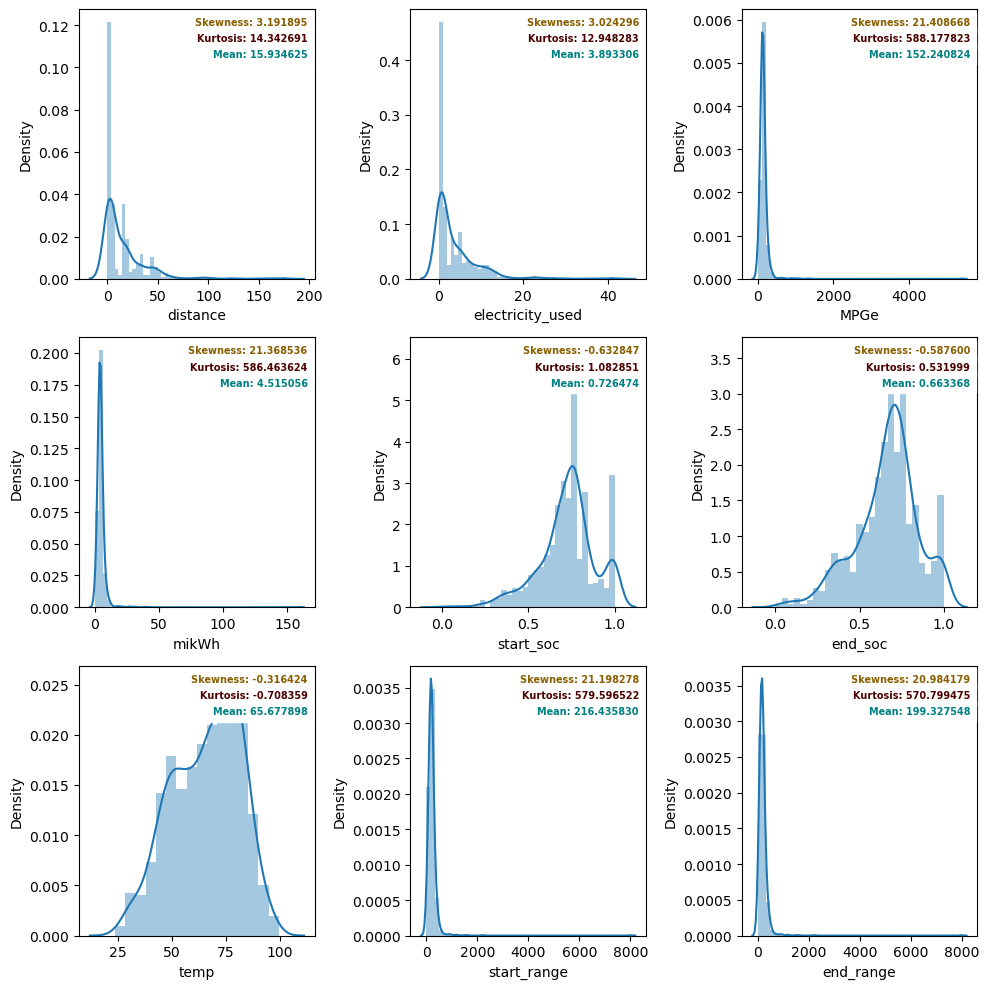

In [30]:
trips_facet = trips.iloc[:,3:12]

f, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=False)
sns.distplot(trips_facet.distance, ax=axes[0,0])
sns.distplot(trips_facet.electricity_used, ax=axes[0,1])
sns.distplot(trips_facet.MPGe, ax=axes[0,2])
sns.distplot(trips_facet.mikWh, ax=axes[1,0])
sns.distplot(trips_facet.start_soc, ax=axes[1,1])
sns.distplot(trips_facet.end_soc, ax=axes[1,2])
sns.distplot(trips_facet.temp, ax=axes[2,0])
sns.distplot(trips_facet.start_range, ax=axes[2,1])
sns.distplot(trips_facet.end_range, ax=axes[2,2])

for i, ax in enumerate(axes.reshape(-1)):
    ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % trips_facet.iloc[:,i].skew(),\
        fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
    ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % trips_facet.iloc[:,i].kurt(),\
        fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')
    ax.text(x=0.97, y=0.85, transform=ax.transAxes, s="Mean: %f" % trips_facet.iloc[:,i].mean(),\
        fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='teal')
plt.tight_layout();



-------------------------------------

The data has a total of ***1092*** observations.

This data takes place in the <u>**temp range 23-100&deg;F**</u>

In [31]:
print(trips.temp.min())
print(trips.temp.max())

23.42
99.54


## Trips by day

In [90]:
# creating a dataframe to summarize information by day
trips_by_day = trips.groupby([trips['start_date'].dt.date]).sum()
trips_by_day

,distance,electricity_used,MPGe,mikWh,start_soc,end_soc,temp,start_range,end_range,gas_price,gas_used_eq,trip_cost_gas_car_eq
start_date,,,,,,,,,,,,
2022-02-24,91.11,25.83,237.90,7.057738,0.5608,0.3216,68.77,127.875155,73.332115,7.384,2.847187,10.511816
2022-02-26,116.90,30.15,805.79,23.884407,4.2981,3.7804,188.43,1132.805331,1000.692367,22.152,3.653125,13.487338
2022-02-27,9.69,3.16,490.81,14.543027,3.0470,2.9922,185.90,726.698532,715.861251,14.768,0.302813,1.117984
2022-02-28,103.29,31.23,223.99,6.645665,1.3020,0.7568,70.49,287.119959,167.936385,7.500,3.227812,12.104297
2022-03-01,35.24,10.82,221.51,6.571455,1.3608,1.1765,74.53,293.044016,253.322589,7.500,1.101250,4.129688
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-26,83.80,23.32,717.53,21.284585,5.0627,4.6784,311.29,1121.002963,1027.274425,22.410,2.618750,9.781031
2022-11-27,10.87,3.75,702.82,20.831242,5.8941,5.8431,292.47,1341.280692,1331.011272,22.410,0.339687,1.268733
2022-11-28,97.83,25.63,380.87,11.299963,2.5020,2.0824,137.98,626.780637,520.699709,10.989,3.057187,11.198478


In [91]:
trips_by_day.distance.mean()

67.44422480620159

In [96]:
trips_by_day.distance.max()

351.69

## distance 
Avg trip <u>**distance**</u> is 15.9 mi

In [95]:
trips.distance.max()

177.48

In [32]:
trips.distance.mean()

15.934624542124526

I've taken 38 trips over 60 mi. 

In [73]:
trips.distance[trips.distance > 90].count()

25

In [80]:
date1 = pd.to_datetime('2/24/22')
date2 = pd.to_datetime('12/17/22')
total_trips_days = date2-date1 # 296 days
trips_per_day = 1092/296
trips_per_day

3.689189189189189

In [74]:
trips.distance.sum()

17400.61

In [69]:
trips[trips.end_soc <.05]

,start_date,end_date,duration,distance,electricity_used,MPGe,mikWh,start_soc,end_soc,temp,start_range,end_range,distance_desc,time_desc,gas_price,gas_used_eq,trip_cost_gas_car_eq
478,2022-09-27 21:00:51,2022-09-27 21:09:23,00:08:32,5.14,0.76,227.98,6.763158,0.051,0.0392,54.84,22.764789,17.497642,Medium Trip,Night,3.542,0.160625,0.568934
863,2022-06-08 19:26:11,2022-06-08 21:16:12,01:50:01,99.54,23.24,144.36,4.283133,0.451,0.0432,75.31,127.491723,12.212067,Long Trip,Night,4.767,3.110625,14.828349
1067,2022-02-24 08:25:56,2022-02-24 09:32:13,01:06:17,45.54,12.64,121.44,3.602848,0.000,0.0000,31.81,0.000000,0.000000,Long Trip,Morning,3.692,1.423125,5.254177


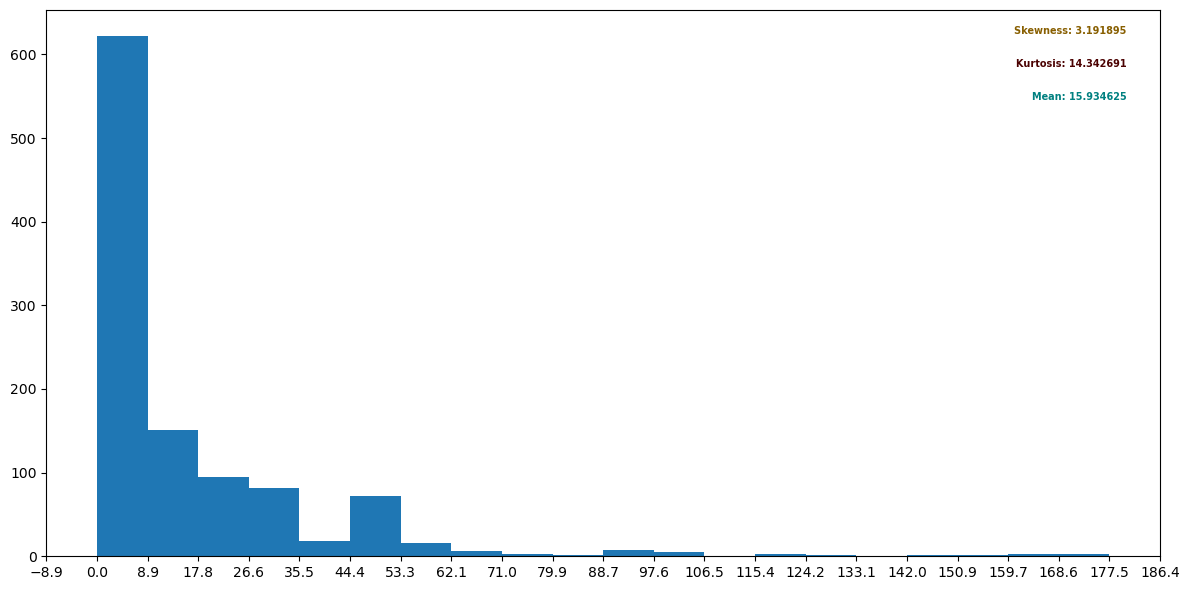

In [34]:
# distance

fig, ax = plt.subplots()
x = trips['distance']

plt.hist(x, bins = 20)
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=23))
ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % x.skew(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='xkcd:poo brown')
ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % x.kurt(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='xkcd:dried blood')
ax.text(x=0.97, y=0.85, transform=ax.transAxes, s="Mean: %f" % x.mean(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='teal')
plt.tight_layout(); 

# fix x axis tickers BIN CUTS it's called. 

### Short trips < 3.3 mi
The distance series is very skewed  to the left (3.19) toward shorter trips. 

Because the data is skewed so much that way, I want to take a look at these shorter trips and see if they are properly distributed and verify the quality of the data.  

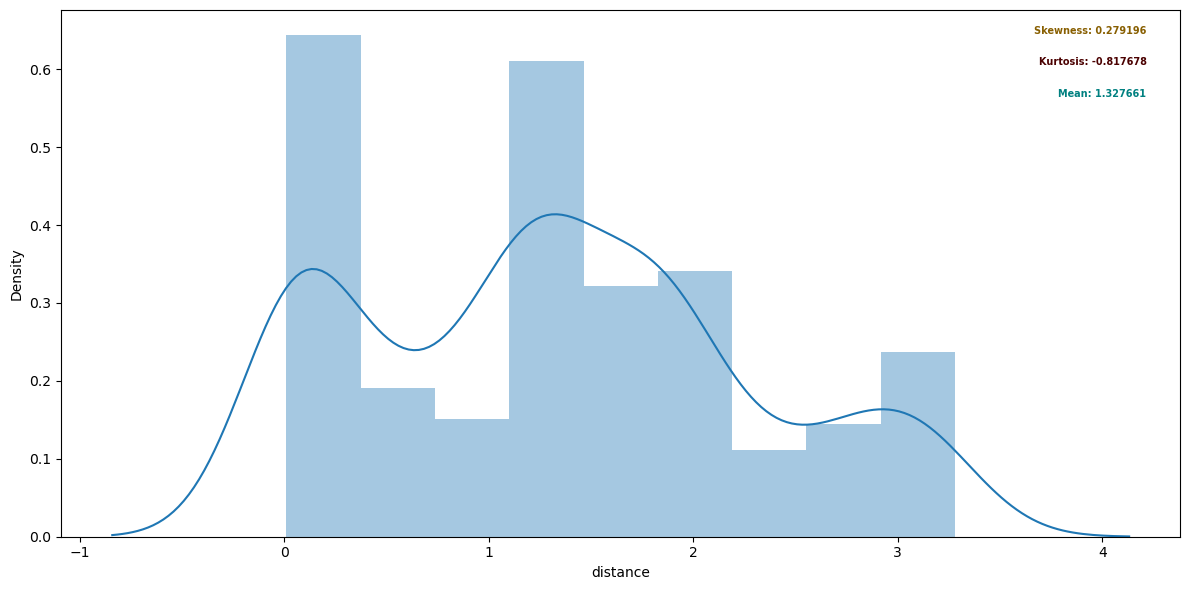

In [99]:
fig, ax = plt.subplots()
x = short_trips.distance
sns.distplot(x)


ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % x.skew(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='xkcd:poo brown')
ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % x.kurt(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='xkcd:dried blood')
ax.text(x=0.97, y=0.85, transform=ax.transAxes, s="Mean: %f" % x.mean(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='teal')
plt.tight_layout();


In [ ]:
### Medium trips

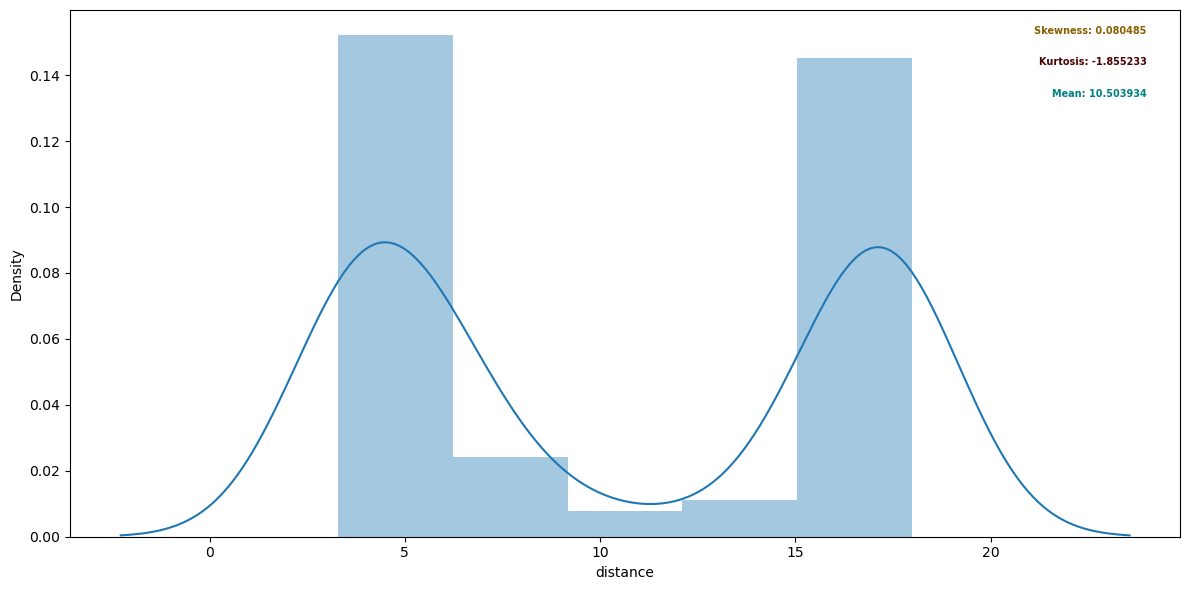

In [100]:
fig, ax = plt.subplots()
x = trips[trips.distance_desc == 'Medium Trip'].distance
sns.distplot(x)


ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % x.skew(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='xkcd:poo brown')
ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % x.kurt(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='xkcd:dried blood')
ax.text(x=0.97, y=0.85, transform=ax.transAxes, s="Mean: %f" % x.mean(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='teal')
plt.tight_layout();

In [ ]:
### Long Trips

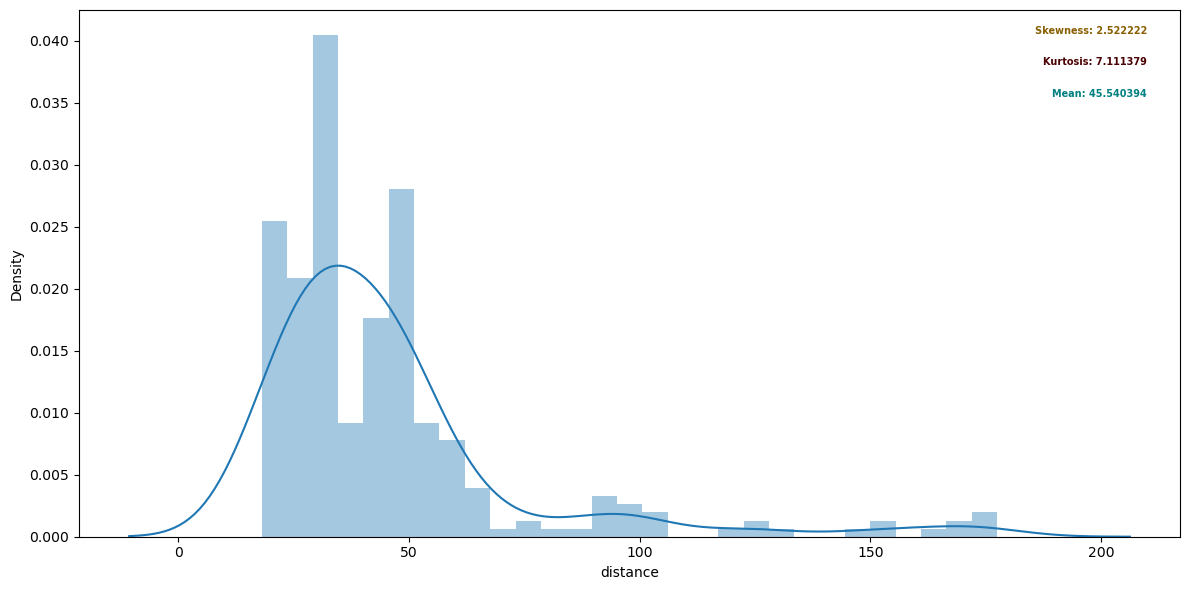

In [101]:
fig, ax = plt.subplots()
x = x = trips[trips.distance_desc == 'Long Trip'].distance
sns.distplot(x)


ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % x.skew(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='xkcd:poo brown')
ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % x.kurt(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='xkcd:dried blood')
ax.text(x=0.97, y=0.85, transform=ax.transAxes, s="Mean: %f" % x.mean(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='teal')
plt.tight_layout();

## electricity_used

An average trip uses <u>**3.89 kWh of energy**</u>.

This represents <u>**5.9%**</u> of the 66kWh Battery's capacity. 

This means if the battery is charged to 100%, on average a Chevy Bolt owner could get <u>**16 trips out of single charge.**</u> 

However, This is unrealistic because you shouldn't start a trip with less than 10%. In my dataset I started a trip with less than 10% <u>**2 times**</u> and ended a trip with less than 10% <u>**7 times**</u>. You also shouldn't really charge past 80% of the capcity. I did this <u>**305 times**</u>. ...Whoops.

So following all the best practices you are looking at an AVG of 11 trips of 15.5mi(3.88 kWh) each per responsible Charge. 

In [36]:
print(trips.electricity_used.mean()/66)
print(66//trips.electricity_used.mean())
print((66*.7)//trips.electricity_used.mean())
print(trips.loc[trips['start_soc']<.10,'distance'].count()) # amount of times I started a trip with less than 10%
print(trips.loc[trips['end_soc']<.10,'distance'].count()) # amount of times I ended a trip with less than 10%
print(trips.loc[trips['start_soc']>.80,'distance'].count()) # amount of times I started a trip with more than 80%

0.0589894827394828
16.0
11.0
2
7
305


11 trips, averaging 15 miles each sounds suffecient to me, but there are consumers that feel this isn't enough. And rightly fully so, considering that the US Federal Highway Administration shows that the average daily miles driven is ***36.9 miles*** * meaning that you could expect to get roughly two days out of the Chevy Bolt before you need to chargeup.

*https://www.fhwa.dot.gov/ohim/onh00/bar8.htm



In [81]:
13476/365
(66*.7)/36.9

1.2520325203252032

However, the interesting thing that most consumer's do not understand, is that the biggest benefit to an electric vehicle is that you have a "Gas Station" in your own home. Every day you come home, you can plug in your vehicle and it's back to full by the next day.

This completely changes way drivers think about the chore of "re-fueling".I RARELY have to go out of my way to refuel this past year. 

Most drivers visit the gas station 2-4 amount of times a month.

I have visited a charging station 12 times this year to charge out of neccesity outside of my garage.  

Average starting <u>**State of Charge(SOC):**</u> is ***70%***, meaning I have followed good charging practices for the health of the battery and that the data is more realistic/representative towards reccomended best practices, and not idealistic numbers. 

In [38]:
trips.start_soc.mean()

0.7264735347985344

****Calculating MPGe****

In order to make any comparisions to gas vehicles we need some sort of conversion. The USA Environmental Protection Agency (EPA) has come up with a converstion to compare MPG to mi/kWh. It is called MPGe or "Miles per gallon equivalent"

Without getting too much in the weeds, the basis behind the conversion is that both burning gasoline and using electricity generates heat. so MPGe is essentially the heat equivalent of MPG. 

1 gallon of gas = 115,000 BTUs = 33.7kWh

<u> The avg MPGe for my trip data is 149.5 </u>

In [39]:
trips.MPGe.mean()

152.24082417582417

and an avg <u>trip effeciency: 4.49 mi/kWh</u>

In [40]:
trips.mikWh.mean()

4.515055595829802

# What do I do with Extreme mikWh values?
it's messing up the visuals and data?


In [41]:
trips.sort_values('MPGe', ascending = False)

,start_date,end_date,duration,distance,electricity_used,MPGe,mikWh,start_soc,end_soc,temp,start_range,end_range,distance_desc,time_desc
0,2022-06-25 20:18:33,2022-06-25 20:25:43,00:07:10,1.59,0.01,5374.05,159.000000,0.7608,0.7608,82.120000,7983.8352,7983.8352,Short Trip,Night
1,2022-07-16 20:43:47,2022-07-16 20:48:01,00:04:14,0.79,0.02,1327.81,39.500000,0.8392,0.8392,78.800000,2187.7944,2187.7944,Short Trip,Night
2,2022-07-26 16:16:48,2022-07-26 16:23:35,00:06:47,1.91,0.06,1072.65,31.833333,0.7098,0.7058,80.600000,1491.2898,1482.8858,Short Trip,Afternoon
3,2022-05-18 20:33:28,2022-05-18 20:39:32,00:06:04,1.81,0.06,1016.80,30.166667,0.3804,0.3764,61.855000,757.3764,749.4124,Short Trip,Night
4,2022-11-03 16:38:58,2022-11-03 16:43:54,00:04:56,1.60,0.06,900.91,26.666667,0.6824,0.6784,65.730000,1201.0240,1193.9840,Short Trip,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,2022-06-30 14:31:39,2022-06-30 14:32:00,00:00:21,0.01,0.00,0.00,0.000000,0.5882,0.5804,82.400000,0.0000,0.0000,Short Trip,Afternoon
1162,2022-07-03 08:20:48,2022-07-03 08:21:02,00:00:14,0.01,0.00,0.00,0.000000,0.6470,0.6470,66.200000,0.0000,0.0000,Short Trip,Morning
1168,2022-07-29 13:43:33,2022-07-29 13:43:53,00:00:20,0.01,0.00,0.00,0.000000,0.7568,0.7568,81.456667,0.0000,0.0000,Short Trip,Afternoon
1171,2022-08-15 12:30:25,2022-08-15 12:30:40,00:00:15,0.01,0.00,0.00,0.000000,0.6196,0.6196,83.545000,0.0000,0.0000,Short Trip,Afternoon


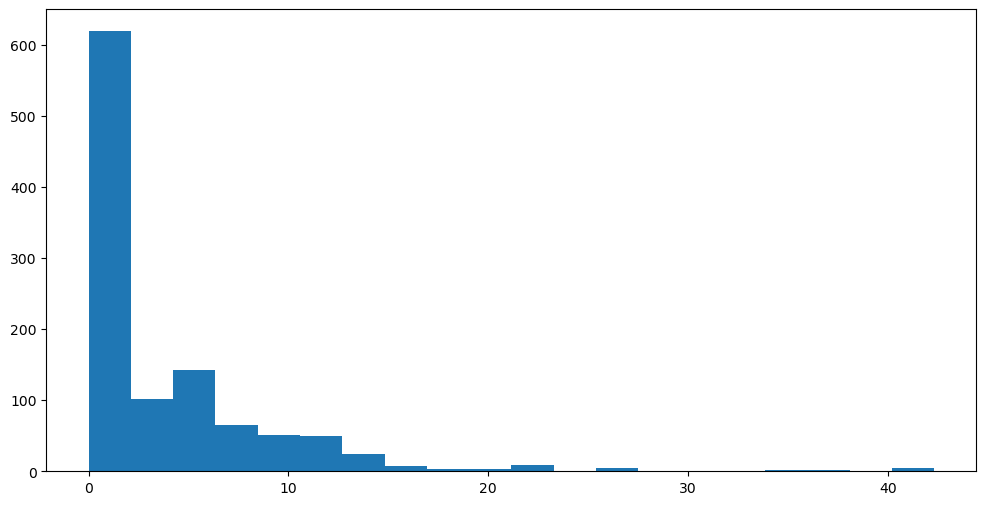

In [42]:
# electricity_used
x = trips['start_date']
y = trips['electricity_used']
plt.hist(y, bins = 20);


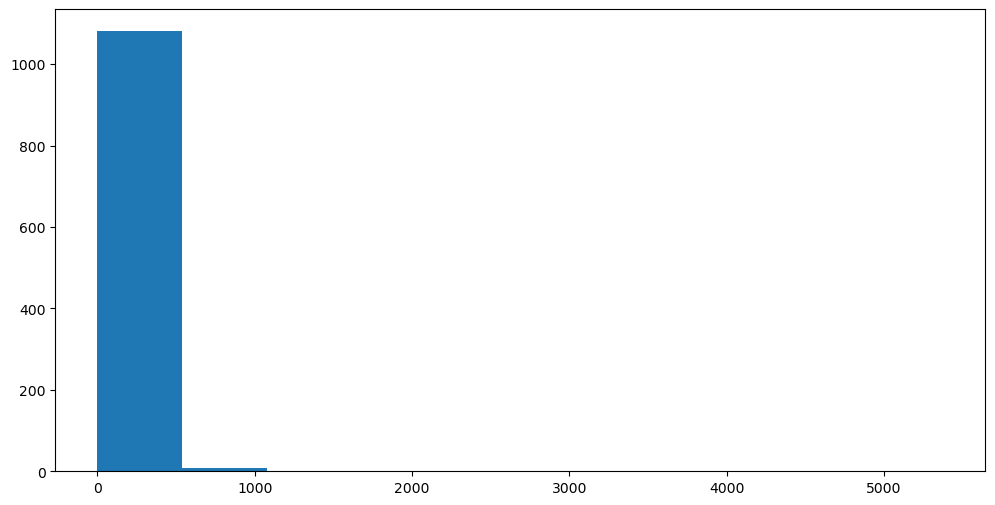

In [43]:
# MPGe
y = trips['MPGe']

plt.hist(y,bins=10);

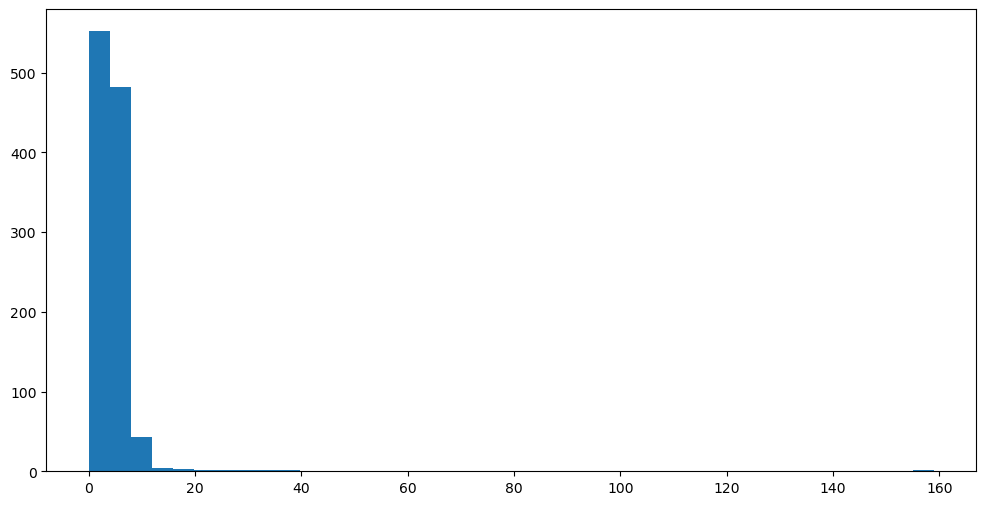

In [44]:
# mikWh
y = trips['mikWh']
plt.hist(y,bins=40);

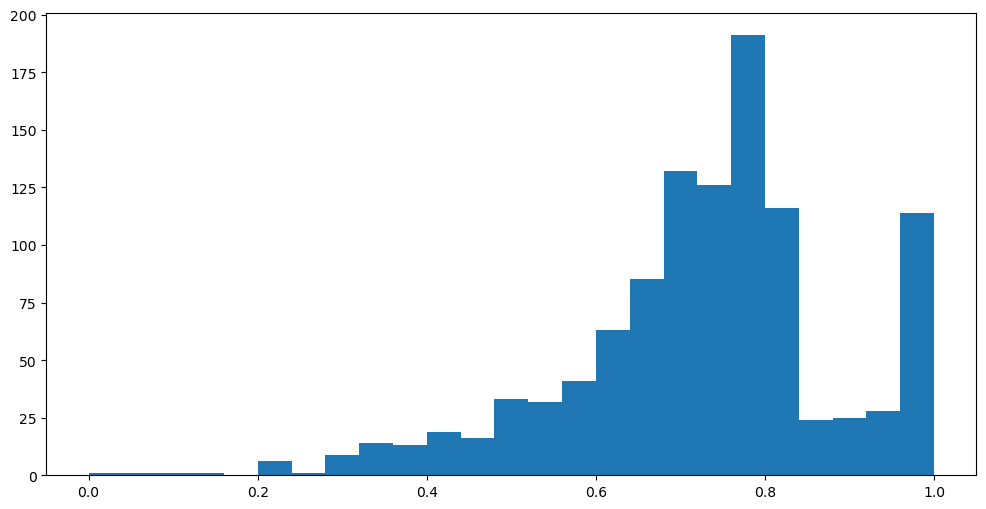

In [45]:
# start_soc
y = trips['start_soc']
plt.hist(y,bins=25);

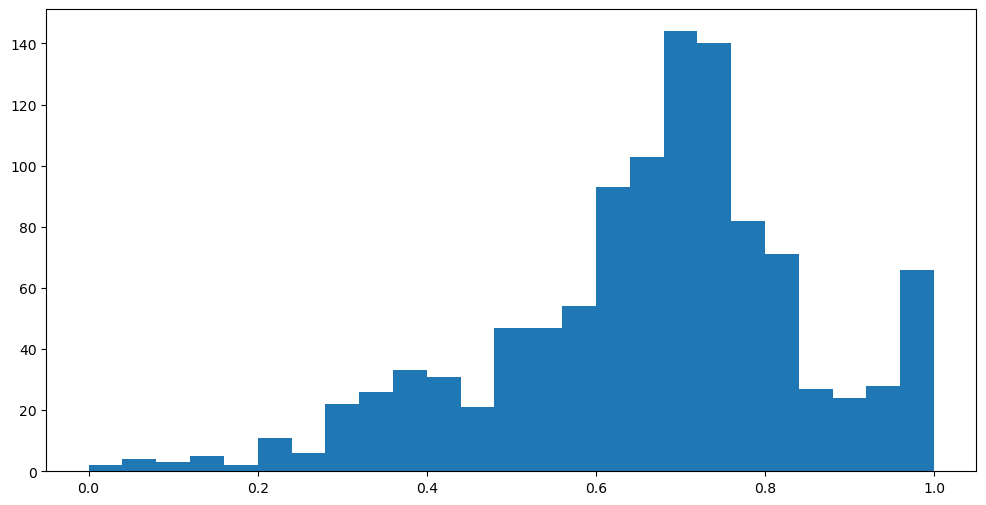

In [46]:
# end_soc
y = trips['end_soc']
plt.hist(y,bins=25);

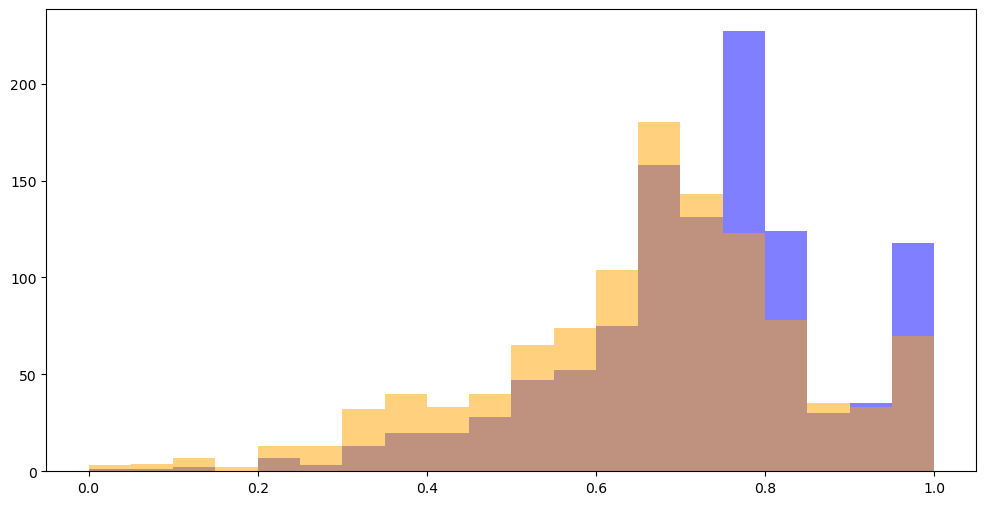

In [72]:
y1 = trips.start_soc
y2 = trips.end_soc
plt.hist(y1, alpha = .5, bins=20, color = 'blue')
plt.hist(y2, alpha = .5, bins=20, color = 'orange');

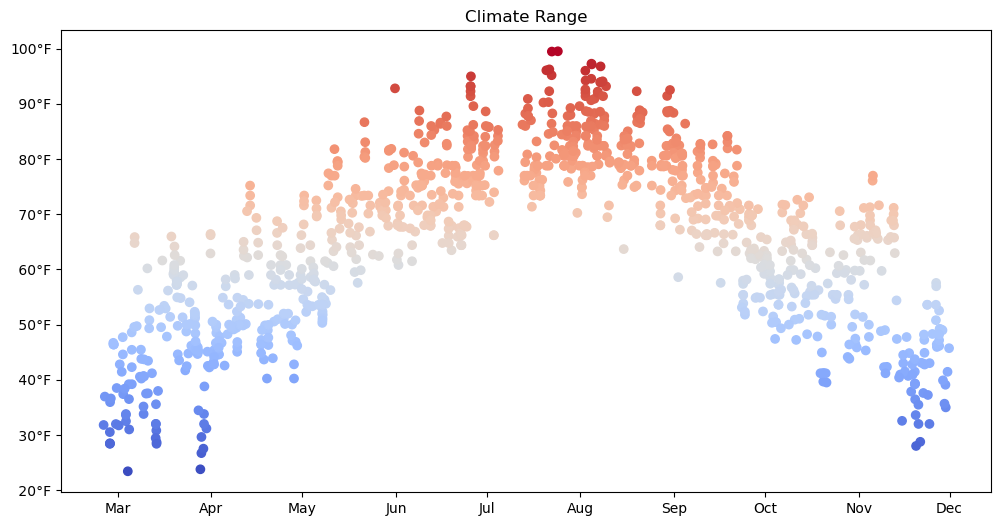

In [47]:
my_fmt = mdates.DateFormatter('%m')

def fahr_format(x, pos):
    """The two arguments are the value and tick position."""
    return '{:3.0f}°F'.format(x)


x = trips['start_date']
y = trips['temp']

fig, ax = plt.subplots()
ax.scatter(x,y,c = trips.loc[:,'temp'], cmap = 'coolwarm')

ax.set_title('Climate Range')

ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.yaxis.set_major_formatter(fahr_format)
# ax.ticklabel_format(axis='y',) FormatStrFormatter('%°f')

# ax.set_yticklabels(['{:,\d}'.format(x) for x in ax])


Text(0.5, 1.0, 'Driving Conditions')

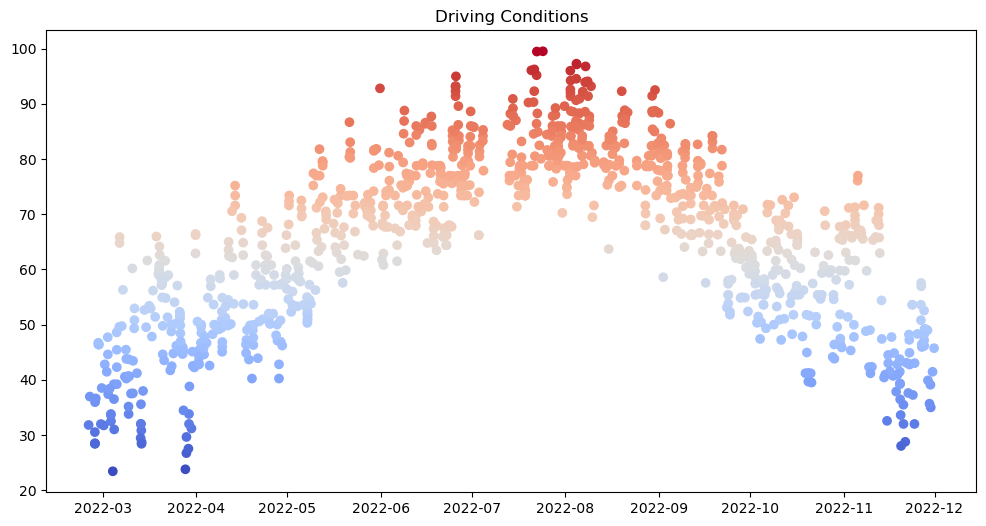

In [48]:
# temp
# my_fmt = mdates.DateFormatter('%d')
# months = mdates.MonthLocator()  # every month

x = trips['start_date']
y = trips['temp']
plt.scatter(x,y, c = trips.loc[:,'temp'], cmap = 'coolwarm')
plt.title("Driving Conditions")

# ax.xaxis.set_major_formatter(my_fmt);

## Range

MOST range with at least 80% battery was ***390 mi***

In [49]:
trips[trips.distance >18].start_range.max()


390.814254180602

LEAST range with at least 80% battery was ***185 mi***

In [50]:
trips[(trips.distance >18) & (trips.start_range > 0) & (trips.start_soc > .8)].start_range.min()

185.1257595

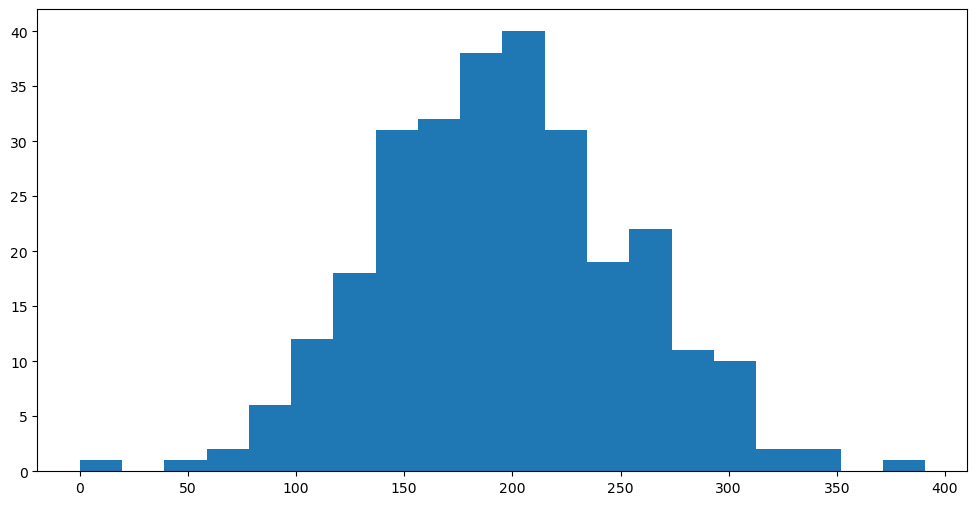

In [51]:
y1 = trips[trips.distance > 18].start_range

plt.hist(y1,bins=20);

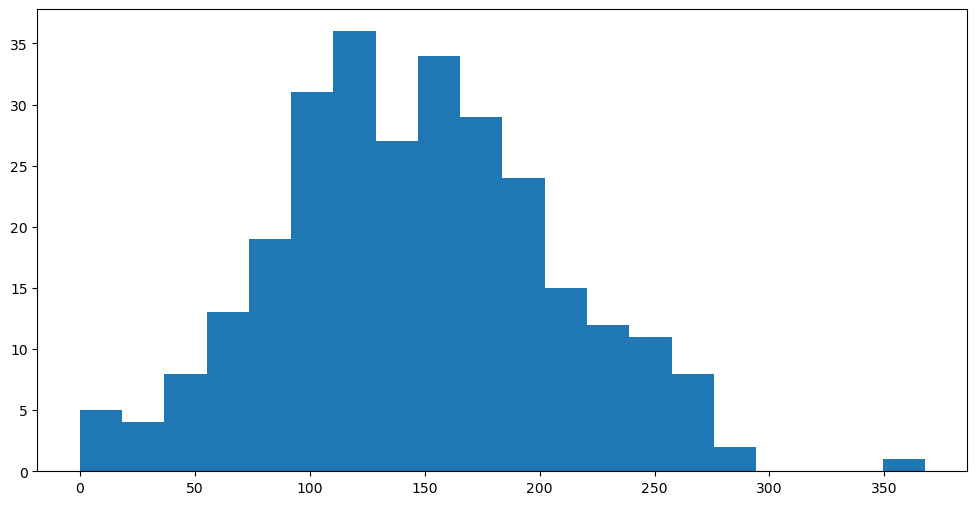

In [52]:
# end_range
y2 = trips[trips.distance > 18].end_range 
plt.hist(y2,bins=20);

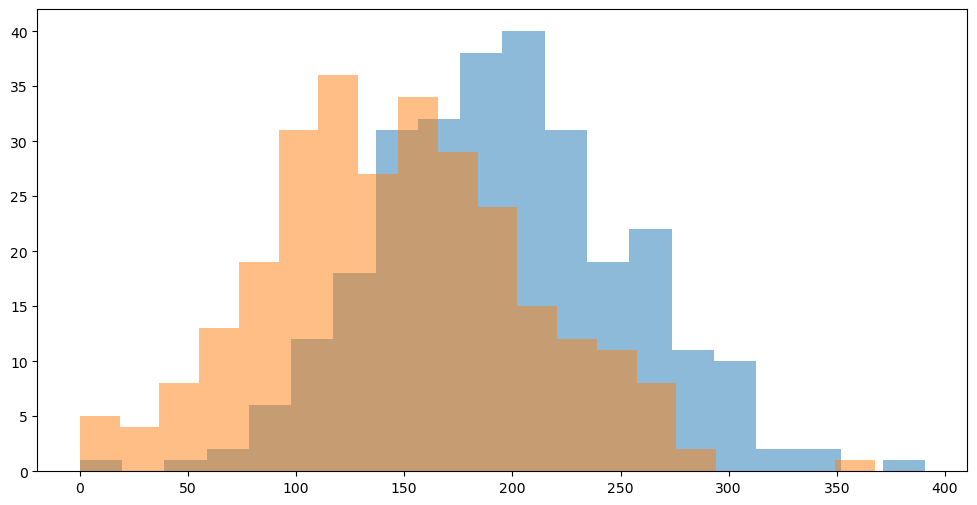

In [53]:
# BOTH ranges overlayed
y1 = trips[trips.distance > 18].start_range
y2 = trips[trips.distance > 18].end_range
plt.hist(y1, alpha = .5, bins=20)
plt.hist(y2, alpha = .5, bins=20);

In [54]:
trips[trips[r'mikWh']<15]

,start_date,end_date,duration,distance,electricity_used,MPGe,mikWh,start_soc,end_soc,temp,start_range,end_range,distance_desc,time_desc
12,2022-11-19 12:38:37,2022-11-19 12:45:15,00:06:38,1.84,0.14,441.90,13.142857,1.0000,1.0000,41.470000,867.428571,867.428571,Short Trip,Afternoon
13,2022-10-09 11:00:19,2022-10-09 11:07:53,00:07:34,2.88,0.23,422.69,12.521739,0.7020,0.7216,59.900000,580.157217,596.355339,Short Trip,Morning
14,2022-07-18 17:25:26,2022-07-18 17:32:27,00:07:01,1.86,0.15,416.91,12.400000,0.7216,0.7176,74.300000,590.557440,587.283840,Short Trip,Afternoon
15,2022-06-09 15:19:40,2022-06-09 15:28:55,00:09:15,2.55,0.22,390.59,11.590909,0.9764,0.9726,71.610000,746.946000,744.039000,Short Trip,Afternoon
16,2022-06-29 19:27:20,2022-06-29 19:33:55,00:06:35,1.85,0.16,388.76,11.562500,0.7294,0.7255,79.700000,556.623375,553.647187,Short Trip,Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,2022-06-30 14:31:39,2022-06-30 14:32:00,00:00:21,0.01,0.00,0.00,0.000000,0.5882,0.5804,82.400000,0.000000,0.000000,Short Trip,Afternoon
1162,2022-07-03 08:20:48,2022-07-03 08:21:02,00:00:14,0.01,0.00,0.00,0.000000,0.6470,0.6470,66.200000,0.000000,0.000000,Short Trip,Morning
1168,2022-07-29 13:43:33,2022-07-29 13:43:53,00:00:20,0.01,0.00,0.00,0.000000,0.7568,0.7568,81.456667,0.000000,0.000000,Short Trip,Afternoon
1171,2022-08-15 12:30:25,2022-08-15 12:30:40,00:00:15,0.01,0.00,0.00,0.000000,0.6196,0.6196,83.545000,0.000000,0.000000,Short Trip,Afternoon


In [55]:
# temp = trips[trips[r'mi/kWh']<15]
# x = temp[r'mi/kWh']
# y = temp[r'Ambient Temperature (F)']
# a, b = np.polyfit(x, y, 1)

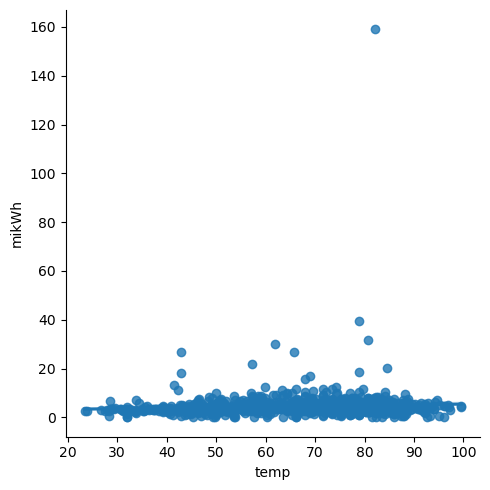

In [56]:
sns.lmplot(y = r'mikWh', x = r'temp', data = trips)


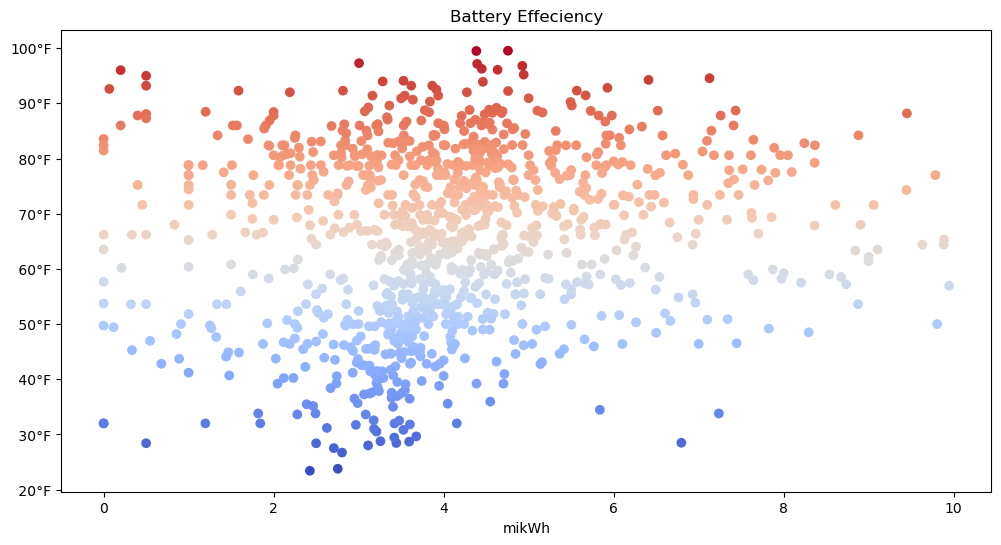

In [144]:
def fahr_format(x, pos):
    """The two arguments are the value and tick position."""
    return '{:3.0f}°F'.format(x)

# values
x = trips[trips[r'mikWh']<10].mikWh
y = trips[trips[r'mikWh']<10].temp

# plotting
fig, ax = plt.subplots()

ax.scatter(x=x, y=y,\
        c = trips.loc[trips[r'mikWh']<10,:][r'temp'],\
        cmap = 'coolwarm', alpha = 1)



# Labelling 
ax.set_title('Battery Effeciency')
ax.set_xlabel('mikWh')
ax.yaxis.set_major_formatter(fahr_format);



# sns.lmplot(x = r'mikWh', y = r'temp', data = temp)
# sns.jointplot(x = r'mikWh', y = r'temp', data = temp);
# temp.plot(x, a*x+b) 


# # Fit linear regression via least squares with numpy.polyfit
# # It returns an slope (b) and intercept (a)
# # deg=1 means linear fit (i.e. polynomial of degree 1)
# b, a = np.polyfit(x, y, deg=1)

# # Create sequence of 100 numbers from 0 to 100 
# xseq = np.linspace(0, 10, num=100)

# # Plot regression line
# ax.plot(xseq, a + b * xseq, color="k", lw=2.5);


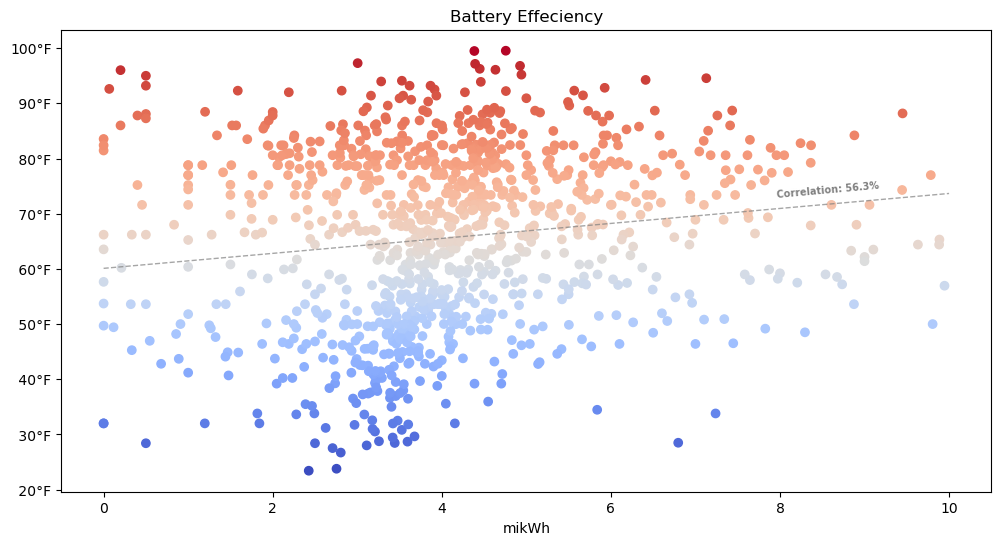

In [182]:
def fahr_format(x, pos):
    """The two arguments are the value and tick position."""
    return '{:3.0f}°F'.format(x)

# values
x = trips[trips[r'mikWh']<10].mikWh
y = trips[trips[r'mikWh']<10].temp

# plotting
fig, ax = plt.subplots()

ax.scatter(x=x, y=y,\
        c = trips.loc[trips[r'mikWh']<10,:][r'temp'],\
        cmap = 'coolwarm', alpha = 1)

# Linear Regression Line
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, 10, num=100)
ax.plot(xseq, a + b * xseq, color="grey", lw=1, linestyle = '--', alpha = .7)

# Labelling 
ax.set_title('Battery Effeciency')
ax.set_xlabel('mikWh')
ax.yaxis.set_major_formatter(fahr_format);

temp_cor = trips[trips.distance>18].corr().temp.mikWh
t = ax.text(x=0.88, y=0.675, transform=ax.transAxes, s = f"Correlation: {temp_cor:.1%}",\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='blue', color='Grey', rotation=5.2)

t.set_bbox(dict(facecolor='white', alpha=0, linewidth=0));

### Summer vs. Winter performance

In [204]:
# 40f and under
cold_avg = trips[(trips.distance>18)&(trips.temp<40)].mikWh.mean()
cold_range = cold_avg*66
print('cold avg:', f'{cold_avg:.2f}')
print('cold range:', f'{cold_range:.2f}')

print('-'*30)

# 70f and above
warm_avg = trips[(trips.distance>18)&(trips.temp>70)].mikWh.mean()
warm_range = warm_avg*66
print('warm avg:', f'{warm_avg:.2f}')
print('warm range:', f'{warm_range:.2f}')

cold avg: 3.49
cold range: 230.55
------------------------------
warm avg: 4.56
warm range: 300.99


In [208]:
(warm_range - cold_range)/cold_range

0.3055512021930977

------

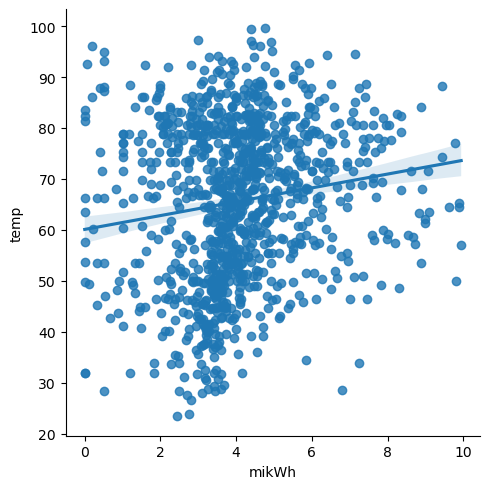

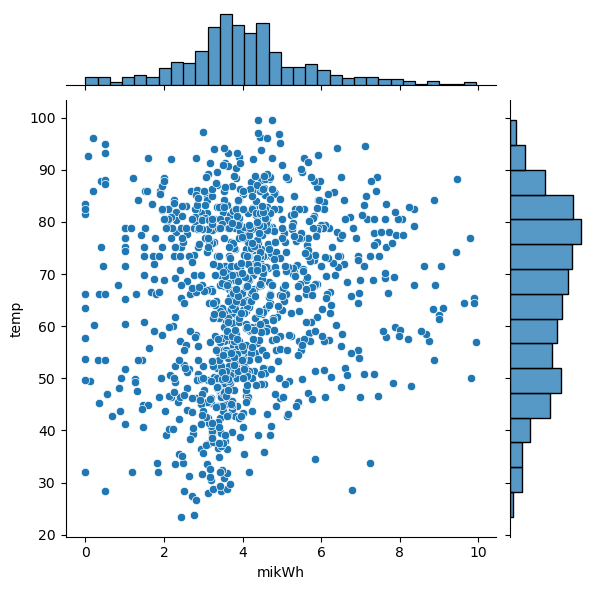

In [128]:
sns.lmplot(x = r'mikWh', y = r'temp', data = temp)
sns.jointplot(x = r'mikWh', y = r'temp', data = temp);

In [58]:
# import numpy as np
# import matplotlib.pyplot as plt

# #define data
# x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
# y = np.array([2, 5, 6, 7, 9, 12, 16, 19])

# #find line of best fit
# a, b = np.polyfit(x, y, 1)

# #add points to plot
# plt.scatter(x, y, color='purple')

# #add line of best fit to plot
# plt.plot(x, a*x+b, color='steelblue', linestyle='--', linewidth=2)

# #add fitted regression equation to plot
# plt.text(1, 17, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=14)

# NEED TO FIX DURATION dtype

In [59]:



# gas_prices['Duration'] = pd.datetime.time to_datetime(gas_prices['date'])
# gas_prices.dtypes

## gas_prices
NY Regular grade gasoline averages per week dating back to year 2000

In [60]:
# Skipping first 7 rows of data because it's the def section

weekly_gas_prices = pd.read_csv('data/RAW-NY_Gas_prices_REGULAR_FORMULA_Weekly_Retail_Gasoline_and_Diesel_Prices.csv'\
                    , skiprows = 7, names = ['date','price'])

weekly_gas_prices.head()

,date,price
0,12/12/22,3.441
1,12/5/22,3.586
2,11/28/22,3.663
3,11/21/22,3.735
4,11/14/22,3.808


In [61]:
# Converting column 'date' to datetime
weekly_gas_prices['date'] = pd.to_datetime(weekly_gas_prices['date'])
weekly_gas_prices = weekly_gas_prices.rename(columns = {'date':'gas_price_date','price':'gas_price'})
weekly_gas_prices

,gas_price_date,gas_price
0,2022-12-12,3.441
1,2022-12-05,3.586
2,2022-11-28,3.663
3,2022-11-21,3.735
4,2022-11-14,3.808
...,...,...
1171,2000-07-03,1.730
1172,2000-06-26,1.711
1173,2000-06-19,1.691
1174,2000-06-12,1.648


In [62]:
# limiting data to 2022
weekly_gas_prices = weekly_gas_prices[weekly_gas_prices['gas_price_date'].dt.year == 2022]
weekly_gas_prices

,gas_price_date,gas_price
0,2022-12-12,3.441
1,2022-12-05,3.586
2,2022-11-28,3.663
3,2022-11-21,3.735
4,2022-11-14,3.808
5,2022-11-07,3.832
6,2022-10-31,3.741
7,2022-10-24,3.586
8,2022-10-17,3.612
9,2022-10-10,3.557


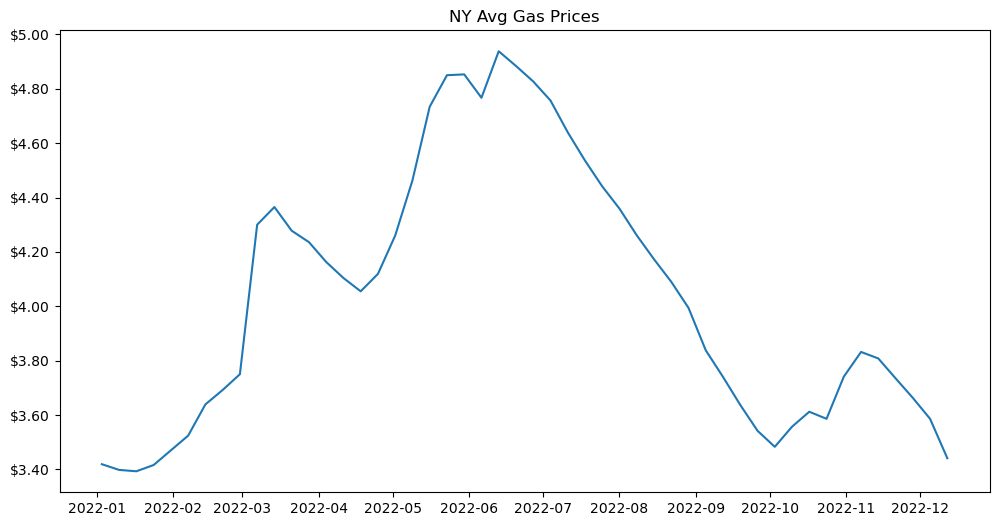

In [63]:
x = weekly_gas_prices.gas_price_date
y = weekly_gas_prices.gas_price

fig, ax = plt.subplots()
ax.plot(x, y)



def dollar_format(x, pos):
    """The two arguments are the value and tick position."""
    return '${:1.2f}'.format(x)

# Labeling
plt.title('NY Avg Gas Prices')
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=12, maxticks=20))
ax.yaxis.set_major_formatter(dollar_format);




# Fill in missing dates, and copy values

In [64]:
# creating a range of dates, DataFrame
raw_dates = pd.DataFrame({'gas_price_date':pd.date_range('01-01-2022', '12-17-2022')})

# matching weekly gas prices to every single day
daily_gas_prices = pd.merge(raw_dates, weekly_gas_prices, how = 'outer',\
                            on = 'gas_price_date')

# .fillna to makesure every day of the week is filled, not just the one that matched previously.
daily_gas_prices = daily_gas_prices.fillna(method = 'ffill', inplace = False)

# I now have a weekly average that I can compare to a daily dataset.
daily_gas_prices


,gas_price_date,gas_price
0,2022-01-01,NaN
1,2022-01-02,NaN
2,2022-01-03,3.419
3,2022-01-04,3.419
4,2022-01-05,3.419
...,...,...
346,2022-12-13,3.441
347,2022-12-14,3.441
348,2022-12-15,3.441
349,2022-12-16,3.441


## Append Gas Data cost to trips

In [65]:
# temporary create new column to easily merge on date data (avoid complicatino of merging datetime to date)
trips['start_date_iso'] = pd.to_datetime(trips.start_date.dt.date)

# merge gas prices on trips DataFrame
trips = pd.merge(trips, daily_gas_prices, left_on = 'start_date_iso', right_on = 'gas_price_date')

# drop temp column and redundent gas_price_date
trips.drop(columns = ['start_date_iso','gas_price_date'], inplace = True)


trips


,start_date,end_date,duration,distance,electricity_used,MPGe,mikWh,start_soc,end_soc,temp,start_range,end_range,distance_desc,time_desc,gas_price
0,2022-06-25 20:18:33,2022-06-25 20:25:43,00:07:10,1.59,0.01,5374.05,159.000000,0.7608,0.7608,82.120,7983.835200,7983.835200,Short Trip,Night,4.884
1,2022-06-25 15:45:32,2022-06-25 15:50:47,00:05:15,0.76,0.21,122.17,3.619048,0.7647,0.7647,93.200,182.654057,182.654057,Short Trip,Afternoon,4.884
2,2022-06-25 16:00:32,2022-06-25 16:06:55,00:06:23,1.24,0.35,119.68,3.542857,0.7568,0.7530,91.400,176.961463,176.072914,Short Trip,Afternoon,4.884
3,2022-06-25 20:28:57,2022-06-25 20:35:15,00:06:18,1.44,0.41,118.46,3.512195,0.7608,0.7568,81.840,176.357151,175.429932,Short Trip,Night,4.884
4,2022-06-25 10:42:28,2022-06-25 10:48:40,00:06:12,1.36,0.44,104.24,3.090909,0.7726,0.7647,85.075,157.610400,155.998800,Short Trip,Morning,4.884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,2022-11-24 08:45:28,2022-11-24 09:12:03,00:26:35,3.53,2.95,40.32,1.196610,0.6000,0.5412,32.000,47.385763,42.741958,Medium Trip,Morning,3.735
1088,2022-08-21 13:14:40,2022-08-21 13:15:47,00:01:07,0.06,0.05,38.54,1.200000,0.3451,0.3568,88.470,27.331920,28.258560,Short Trip,Afternoon,4.173
1089,2022-03-12 07:59:54,2022-03-12 08:01:07,00:01:13,0.01,0.01,20.94,1.000000,0.4824,0.5333,41.190,31.838400,35.197800,Short Trip,Morning,4.300
1090,2022-04-07 17:48:09,2022-04-07 17:49:53,00:01:44,0.02,0.17,4.19,0.117647,0.7451,0.7372,49.420,5.785482,5.724141,Short Trip,Afternoon,4.163


In [66]:
# Our other car is a 2005 Toyota Corolla and gets 32/41 mpg, it's an old car so let's assume it's mpg is on the lower end
trips['gas_used_eq'] = trips.distance/32
trips['trip_cost_gas_car_eq'] = trips.gas_used_eq * trips.gas_price

trips.sort_values('distance', ascending = False)

,start_date,end_date,duration,distance,electricity_used,MPGe,mikWh,start_soc,end_soc,temp,start_range,end_range,distance_desc,time_desc,gas_price,gas_used_eq,trip_cost_gas_car_eq
949,2022-10-07 17:00:35,2022-10-07 20:48:53,03:48:18,177.48,40.52,147.63,4.380059,0.9647,0.2941,71.670,278.879247,85.019578,Long Trip,Afternoon,3.483,5.546250,19.317589
950,2022-10-07 21:41:25,2022-10-08 00:50:02,03:08:37,174.21,41.34,142.03,4.214078,0.7686,0.1059,64.920,213.770082,29.453879,Long Trip,Night,3.483,5.444063,18.961670
919,2022-06-10 11:17:29,2022-06-10 14:59:28,03:41:59,173.95,38.80,151.11,4.483247,0.8470,0.2236,83.010,250.622497,66.161972,Long Trip,Morning,4.767,5.435937,25.913114
769,2022-06-12 20:04:52,2022-06-12 23:01:39,02:56:47,168.57,37.97,149.63,4.439558,0.7412,0.1334,73.520,217.179603,39.087640,Long Trip,Night,4.767,5.267812,25.111662
84,2022-10-09 20:33:10,2022-10-09 23:33:32,03:00:22,168.05,40.82,138.76,4.116854,0.7372,0.0628,53.270,200.306378,17.063538,Long Trip,Night,3.483,5.251563,18.291192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,2022-03-26 12:35:37,2022-03-26 12:36:17,00:00:40,0.01,0.01,39.79,1.000000,0.8274,0.8274,51.800,54.608400,54.608400,Short Trip,Afternoon,4.278,0.000313,0.001337
385,2022-08-15 12:30:25,2022-08-15 12:30:40,00:00:15,0.01,0.00,0.00,0.000000,0.6196,0.6196,83.545,0.000000,0.000000,Short Trip,Afternoon,4.173,0.000313,0.001304
351,2022-08-27 11:34:31,2022-08-27 11:34:55,00:00:24,0.01,0.01,50.26,1.000000,0.9960,0.9960,74.400,65.736000,65.736000,Short Trip,Morning,4.090,0.000313,0.001278
1000,2022-03-13 15:06:32,2022-03-13 15:06:57,00:00:25,0.01,0.00,0.00,0.000000,0.5412,0.5412,32.000,0.000000,0.000000,Short Trip,Afternoon,4.300,0.000313,0.001344


## Scraping utility bill .pdfs for electricity prices

In [67]:
directory = 'data/utility_bills'

# lists to populate
bill_dates = []
supply_charge_rate = []
delivery_charge_rate = []

# iterate over utility bill .pdfs in directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    
    if os.path.isfile(f): # checking if it is a file
        with open(f,'rb') as file:
            reader = PyPDF2.PdfReader(f)
            page = reader.pages[1].extract_text() # 2nd page and extracted text
        
        bill_dates.append(re.findall('Electric Meter Detail - billing period from (\w+ \w+, \w+)  to (\w+ \w+, \w+)', page))
        supply_charge_rate.append(re.findall('Supply \d{0,2},*\d{2,5} \s{0,1}kWh @(\d{1,2}.\d{1,5})', page))
        delivery_charge_rate.append(re.findall('Delivery \d{0,2},*\d{2,5} kWh @(\d{1,2}.\d{1,5})', page))
       
    
print(bill_dates)
print('-'*56)
print(supply_charge_rate)
print('-'*56)
print(delivery_charge_rate)



PdfReadError: EOF marker not found

In [ ]:
# flatten out list of lists
bill_dates_flat = [num for sublist in bill_dates for num in sublist]
supply_charge_rate_flat = [num for sublist in supply_charge_rate for num in sublist]
delivery_charge_rate_flat = [num for sublist in delivery_charge_rate for num in sublist]

# unpack tuples
bill_start = []
bill_end = []
for i in bill_dates_flat:
    bill_start.append(i[0])
    bill_end.append(i[1])


print(bill_start)
print('-'*56)
print(bill_end)
print('-'*56)
print(supply_charge_rate_flat)
print('-'*56)
print(delivery_charge_rate_flat)

In [ ]:
# creating dataframe from extracted data
utility_bill = pd.DataFrame({'bill_start': bill_start,
              'bill_end' : bill_end,
              'supply_charge_rate': supply_charge_rate_flat,
              'delivery_charge_rate' : delivery_charge_rate_flat
             })
# converting text dates, to datetime
utility_bill['bill_start'] = pd.to_datetime(utility_bill['bill_start'])
utility_bill['bill_end'] = pd.to_datetime(utility_bill['bill_end'])

# converting str to floats
utility_bill = utility_bill.astype({'supply_charge_rate': 'float', 'delivery_charge_rate': 'float'})

# adding up all fees to one combined electricity rate column
utility_bill['electric_price'] = (utility_bill.supply_charge_rate/100)+ (utility_bill.delivery_charge_rate/100)

# dropping the other rate columns
utility_bill.drop(columns = ['supply_charge_rate','delivery_charge_rate'], inplace = True)

# filtering to only 2022
utility_bill = utility_bill[utility_bill.bill_start.dt.year == 2022]

# creating a range of dates, DataFrame
raw_dates = pd.DataFrame({'bill_start':pd.date_range('01-01-2022', '12-17-2022')})

# matching weekly gas prices to every single day
daily_electric_prices = pd.merge(raw_dates, utility_bill, how = 'outer',\
                            on = 'bill_start')

# .fillna to makesure every day of the week is filled, not just the one that matched previously.
daily_electric_prices = daily_electric_prices.fillna(method = 'ffill', inplace = False)

# filtering to trips date range
daily_electric_prices = daily_electric_prices[daily_electric_prices.bill_start >= '2022-02-24']

# dropping bill_end date and renaming bill start
daily_electric_prices = daily_electric_prices.drop(columns = 'bill_end')
daily_electric_prices = daily_electric_prices.rename(columns = {'bill_start':'electric_price_date'})


# I now have a weekly average that I can compare to a daily dataset.
daily_electric_prices


## Write Electric Prices to .csv

In [ ]:
daily_electric_prices.to_csv('data/CLEAN-Scraped-utility-electricity-prices.csv', sep=',', encoding='utf-8')

## Append Electric Prices to Trips Dataset

In [ ]:
# temporary create new column to easily merge on date data (avoid complicatino of merging datetime to date)
trips['start_date_iso'] = pd.to_datetime(trips.start_date.dt.date)

# merge electric prices on trips DataFrame
trips = pd.merge(trips, daily_electric_prices, left_on = 'start_date_iso', right_on = 'electric_price_date')

# drop temp column and redundent electric_price_date
trips.drop(columns = ['start_date_iso','electric_price_date'], inplace = True)


trips

In [ ]:
# adding column for cost of electricity per trips

trips['trip_cost'] = trips.electricity_used * trips.electric_price
trips.sort_values('distance', ascending = False)

## Gas vs electric: Cost Comparision

In [ ]:
fig, ax = plt.subplots()

x = trips.distance
y1 = trips.trip_cost
y2 = trips.trip_cost_gas_car_eq

def dollar_format(x, pos):
    """The two arguments are the value and tick position."""
    return '${:1.2f}'.format(x)

plt.scatter(x,y1, color = '#8D0206', alpha = .3, s = 40)#red electric car
plt.scatter(x,y2, color = '#F2BE50', alpha = .3, s = 40)#champagne gas car




# labelling 

ax.text(x=0.97, y=0.55, transform=ax.transAxes, s = "Electric Avg Cost: $%1.2f" % y1.mean(),\
    fontweight='demibold', fontsize=12, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='#8D0206')

ax.text(x=0.97, y=0.61, transform=ax.transAxes, s="Gas Avg Cost: $%1.2f" % y2.mean(),\
    fontweight='demibold', fontsize=12, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='#F2BE50')

plt.title('Cost Per Trip', fontsize = 25)
ax.set_xlabel('Trip Distance')
ax.set_ylabel('Trip Cost') 
ax.yaxis.set_major_formatter(dollar_format);

## Money Saved this year

In [ ]:
trips.trip_cost_gas_car_eq.sum()-trips.trip_cost.sum()